In [ ]:
# default_exp kelly_criterion

# Kelly Criterion

> Exploration into Kelly Criterion

In [ ]:
%matplotlib inline

from ipywidgets.widgets import interact
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import sympy.stats as ss
import pandas as pd

plt.rcParams['figure.figsize'] = 10, 6
sp.init_printing()

# Exploring the Kelly criterion

Kelly criterion according to Wikipedia
$$ k = \frac{\text{expected net winnings}}{\text{net winnings if you win}}
     = \frac{pg - (1-p)l}{g}
$$
Defining $b = g/l$ and dividing nominator and denominator by $l$:
$$   k = \frac{pb - (1-p)}{b} = p - \frac{1 - p}{b}
       = \frac{p(b+1) - 1}{b} 
$$

### Derivation

**Warning: some sign confusion about $r_l$ ahead**

Iteration: Starting with value $v_0 = 1$, we iterate

$$
v_{n+1} = v_{n} (1 + l r_w)^{W_1} (1 - l r_l)^{L_1}
$$

Where $W_1, L_1 \in [0, 1]$, depending on won or lost,
$l$ fraction of total funds bet, $r_w$, $r_l$ fraction of bet payed out or discarded (win/loss).

$$
v_{n} = v_{0} (1 + l r_w)^{W} (1 - l r_l)^{L} \approx (1 + l r_w)^{pN} (1 - l r_l)^{(1-p)N}
$$
$$
l^* = \operatorname*{argmax}_l \frac{v_n}{v_0} = 
\operatorname*{argmax}_l \log\frac{v_n}{v_0} = \operatorname*{argmax}_l ( pN \log(1 + l r_w) + (1-p)N \log(1 - l r_l))
$$
$$
l^* = -\frac{pr_w+ (1-p)r_l}{r_lr_w} = -\frac{p}{r_l} - \frac{1-p}{r_w}
$$

Compared to the Wikipedia result, we see that the Wikipedia result is a special case for $r_l = -1$ (the whole bet is forfeited at loss).

Note that we did NOT introduce the logarithm by external intuition. It is merely a mathematical helper for easier solution of the argmax problem! In our derivation, we maximize the gain in each round. But optimizing "the gain" is a bit sloppy language, that we will clean up using the random variable formalism down below.

# Extensions to multiple outcomes on the same bet

We go from (win, loss) to a continuum of outcomes, e.g. 20% full loss, 20% half-loss, 40% half-win, 20% full-win. In this case, the argmax equation
is still easy to construct:

$$
l^* = \operatorname*{argmax}_l \frac{v_n}{v_0} = 
 \operatorname*{argmax}_l \sum_i p_i \log(1 + l r_i)
$$

Where the $i$'s go over all possible outcomes of a single game. This is not analytically solvable for $l^*$ any more. Fortunately, numerical solutions are easy to find.

Let's consider a game with outcomes $r \in \{-1, -0.5, 0, 1, 2\}$, all with equal probability $p = p_i = 0.2$.


ROI of one round:


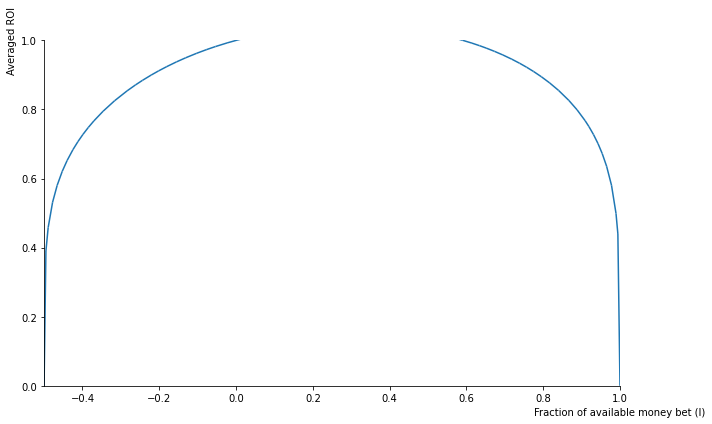

ROI of 250 rounds:


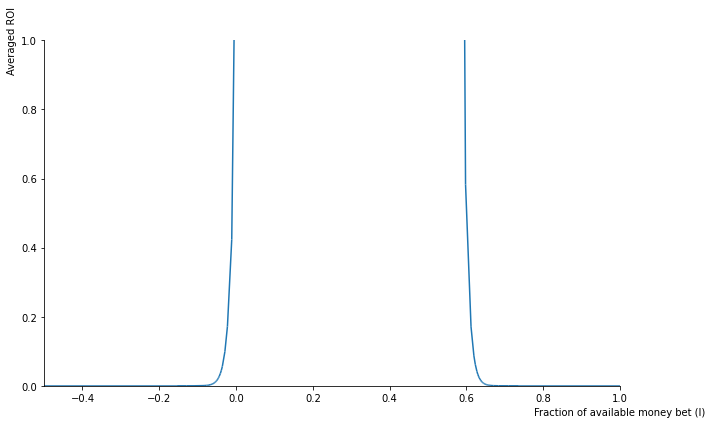

Optimal l: 0.301, expected ROI per round: 1.044


In [ ]:
class Kelly:
    def __init__(self, returns, probabilities):
        self.returns = returns
        self.probabilities = probabilities
        
        try:
            self.min_return = min(ri for ri, pi in zip(returns, probabilities) if pi != 0)
            self.max_return = max(ri for ri, pi in zip(returns, probabilities) if pi != 0)

            self.min_l = -1 / self.max_return
            self.max_l = -1 / self.min_return
        except Exception:
            pass

        self.l = sp.symbols('l')
        self.G = sum(pi*sp.ln(1+self.l * ri) for ri, pi in zip(returns, probabilities))
        self.G1 = sp.diff(self.G, self.l)
        self.G2 = sp.diff(self.G1, self.l)
        
    def solve(self):
        l_solution = sp.nsolve(self.G1, 0.5)
        G_solution = self.G.subs(self.l, l_solution)

        assert sp.im(G_solution) == 0, "Could not find a solution over the reals"
        assert self.G2.subs(self.l, l_solution) < 0, "Found a stationary point, but no maximum."

        return float(l_solution), sp.exp(G_solution)
    
    def plot(self, rounds=1):
        y = sp.exp(self.G) ** rounds
        sp.plotting.plot(y,
                         (self.l, self.min_l, self.max_l),
                         axis_center=(self.min_l, 0),
                         xlabel='Fraction of available money bet (l)',
                         ylabel='Averaged ROI')
        
    def _iteration_step(self, v, l):
        ret = np.random.choice(self.returns, p=self.probabilities, size=v.shape)
        return v * (1 + l * ret)
    
    def simulate(self, l, num_players, rounds):
        valuations = np.ones((num_players, rounds + 1))
        for i in range(rounds):
            valuations[:, i+1] = self._iteration_step(valuations[:, i], l)
        return valuations

    
p = [0.2] * 5
r = [-1, -0.5, 0, 1, 2]

k = Kelly(r, p)
print("ROI of one round:")
k.plot()
print("ROI of 250 rounds:")
k.plot(250)
print('Optimal l: %.03f, expected ROI per round: %.03f' % k.solve())

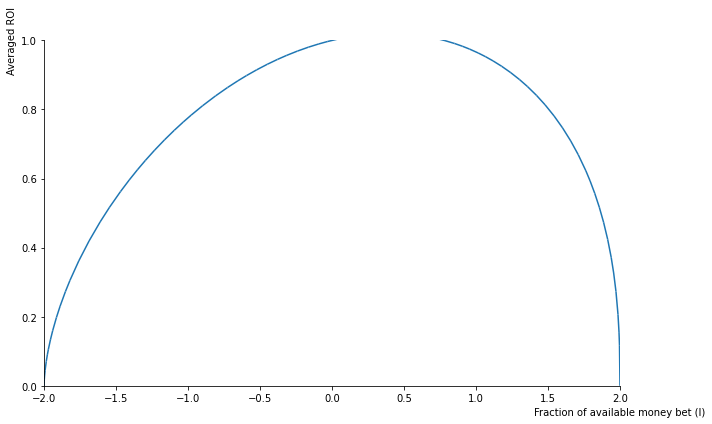

In [ ]:
Kelly([-0.5,0.5], [0.4, 0.6]).plot()

In [ ]:
def cumulative_plot(row, title=None):
    bins = 200
    xmin, xmax = -0.5, 2
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.hist(row, bins=np.linspace(xmin, xmax, bins), density=True)
    ax.set_xlim(xmin, xmax)
    ax.axes.get_yaxis().set_visible(False)
    if title:
        ax.set_title(title)
    return fig
    
def plot_simulation(k, l, num_players, rounds, title=None):
    arr = k.simulate(l, num_players, rounds)
    result = arr[:, -1]**(1/rounds)
    fig = cumulative_plot(result, title=title)
    print("Mean: %.04f, Median: %.04f, kelly-l: %0.02f, gain: %0.04f" % (
        np.mean(result),
        np.median(result),
        k.solve()[0],
        k.solve()[1],
    ))
    return fig
    


def plot_simulation_rp(l, rounds):
    plot_simulation(Kelly(r,p), l, num_players=1000, rounds=rounds)
    
interact(plot_simulation_rp, l=(0, 1, 0.05), rounds=(1, 500));

interactive(children=(FloatSlider(value=0.0, description='l', max=1.0, step=0.05), IntSlider(value=250, descri…

In [ ]:
def plot_simulation_binary(l, p, r0, r1, rounds):
    k = Kelly([r0, r1], [p, 1-p])
    plot_simulation(k, l, num_players=1000, rounds=rounds)

interact(plot_simulation_binary, l=(0, 1, 0.05), p=(0., 1., 0.1), r0=+1.0, r1=-1.0, rounds=(1, 500));

interactive(children=(FloatSlider(value=0.0, description='l', max=1.0, step=0.05), FloatSlider(value=0.5, desc…

Mean: 1.0214, Median: 1.0195, kelly-l: 0.30, gain: 1.0195


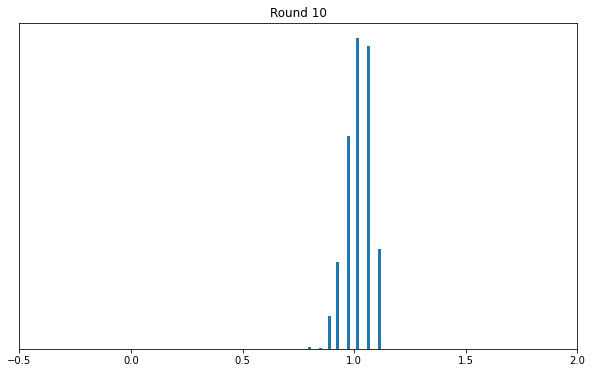

In [ ]:
def plot_simulation_binary_video(rounds):
    l = 0.3
    p = 0.8
    r0 = 0.4
    r1 = -1
    k = Kelly([r0, r1], [p, 1-p])
    fig = plot_simulation(k, l, num_players=1000, rounds=rounds,
                          title="Round %d" % rounds)
    
plot_simulation_binary_video(10)

# Playing around with random variables and expectation values

We regard $\frac{v_{n+1}}{v_n}$ as a random variable in its own right, depending on a random variable $X$, the outcome of our game. If $X = -1$ all bet money is lost, $X=0$ represents no gain/loss, $X=3$ means: we get our bet money + 3 times as much.

Calculating expectation value of $\frac{v_{n+1}}{v_n}$:

$$
f_1 = \frac{v_{n+1}}{v_n} = (1-l) + l(1+X) = 1 + lX
$$


In [ ]:
l = sp.Symbol('l')
f1 = lambda Z: 1+l*Z  # f1 = 1-l + l(1+Z) = 1 + lZ

# X is the outcome of the gamble, with 70% chance you loose all, with 30% you win 3x your bet
X = ss.FiniteRV('X', {-1: 0.7, 3:0.3})

ss.E(f1(X))

So the expectation value is increasing linearly with $l$ - the more you can invest, the more you will gain - interesting. This is in contrast to
what Kelly tells us to do.

### Equivalence between linear and exponential representation

We define a new Bernoulli random variable $Y$, which captures only the probability (30% $1$, 70% $0$). We encode the outcomes (-1, 3) into our formula $f_2$ instead of into the random variable:

In [ ]:
Y = ss.Bernoulli('Y', 0.3)
f2 = (1+l*3)**Y * (1-l)**(1-Y) 
ss.E(f2)

In [ ]:
#ss.density(f1)

In [ ]:
ss.density(f2)

In [ ]:
#ss.density(f1) == ss.density(f2)

Thus, the two formulations $f_1, f_2$ describe of the same phenomenon and lead to the same outcomes.

### Multiple rounds of games

Let's look at the density of $\frac{v_{n+10}}{v_n}$:

In [ ]:
ss.density(f1(X)**10)

**Eek! We need to be careful here. The same X value was taken in each multiplication, missing the mixed powers. This is wrong!**

So we need to take care not to take the power of $f1$ which would mean taking exactly the same $X$ (same outcome). We need multiple $X_i$, which should be drawn from the same distribution, but have differing outcomes.
$$
\prod_{i=1}^{N} (1+lX_i) \ne (1+lX)^N
$$

Let's see how it looks with independent x_i.

In [ ]:
N = 10
fN = sp.prod([f1(ss.FiniteRV('X_%d' % i, {-1: 0.7, 3:0.3})) for i in range(N)])
fN

This gives us the correct density which includes mixed powers:

In [ ]:
dens_fN = ss.density(fN)
dens_fN

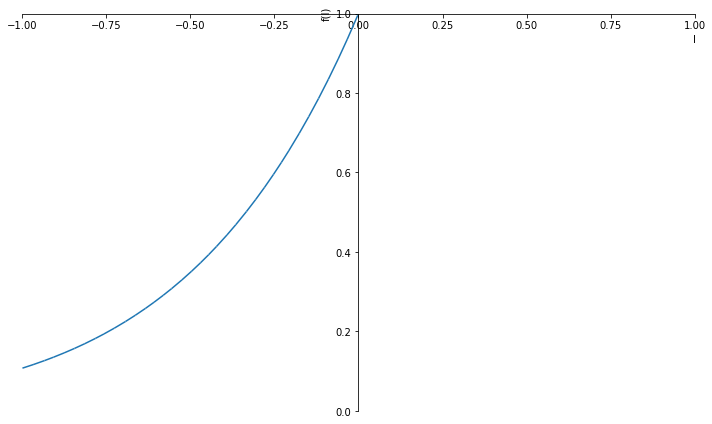

In [ ]:
sp.plot(ss.E(fN), (l, -1, 1), axis_center=(0,1.0));

In [ ]:
sp.expand(ss.E(fN))

$E(f_N)$ is still growing with $l$?!

Let's explore the density in more detail:

In [ ]:
def density_df(dens_fn, l_actual):
    dens_fn_concrete = [(k.subs(l, l_actual), v) for k, v in dens_fn.dict.items()]
    df = pd.DataFrame(sorted(dens_fn_concrete), columns=('outcome', 'probability'))
    df = df.apply(lambda series: series.apply(float))
    df['outcome'] = df.outcome.apply(lambda v: max(v, 1E-3))
    df = df.groupby(df.outcome).sum().reset_index()
    df['E_contribution'] = df.prod(axis=1)
    return df

    
def plot_density(l_actual):
    df = density_df(dens_fN, l_actual)
    df.plot.scatter('outcome', 'probability', logx=True, xlim=[1E-4, 1E5])
    
    sum_series = df.sum()
    sum_series.name = 'SUM'
    return df.append(sum_series)
    return df

interact(plot_density, l_actual=(0.0, 1.0, 0.01));

interactive(children=(FloatSlider(value=0.5, description='l_actual', max=1.0, step=0.01), Output()), _dom_clas…

Here, SUM(E_contribution) is the expectation value.

As can be seen, the highest contributors are the entries with low probabilities.
As $l$ increases, the largest outcomes start to dominate, despite their miniscule probabilities.

Because of the correspondence between expectation value and center of mass, we can think of the highest outcome as a sand grain (small probability) sitting on an extremely long lever arm (large outcome), which tips the balance of mass to the right.

This seems somehow related to the [St. Petersburg paradox](https://en.wikipedia.org/wiki/St._Petersburg_paradox). Another way to look at it is to say that the expecation value doesn't correspond to our intuition, since it weighs improbable events too heavily.

### Understanding the dichotomy between expectation value and Kelly

Since the expectation value doesn't lead to a sensible $l$, how did we come up with our Kelly formula for $l^*$ in the introduction? The tricky step was that we did not maximize the expectation value, but the mode of the probability distribution. The key tricky step is here:

$$ v_{n} = v_{0} (1 + l r_w)^{W} (1 - l r_l)^{N-W} $$
$$ v_{n} \approx (1 + l r_w)^{pN} (1 - l r_l)^{(1-p)N} $$

In the first line, $W$ can of course be interpreted as the *number* of wins in the $N$ games played. But crucially, it can also be regarded as a *random variable* describing the number of games won! So the first equation can be seen as a random variable $v_n$ being defined!

In contrast, in the second equation, we have substituted the variable $W$ for its mode $pN$! This resonates with

# Multiple investment opportunities

Simple case:
$$
v_{n+1} = v_n \prod_{i} (1 + l r_i)^{p_i^*} = v_n (1+lr_w)^W (1+lr_l)^L = v_n + v_n l r_w W + v_n l r_l L = (1-l)v_n + lv_n + v_n (l r_w W + l r_l L)
$$
$$
= (1-l)v_n + lv_n (1 + r_w W + r_l L) = (1-l) v_n + lv_n (1+r_w)^W (1+r_l)^L = v_n \left( (1-l) + l (1+r_w)^W (1+r_l)^L \right)
$$
$$
= v_n \left( (1-l) + l R_w^W R_l^L \right)
$$
If the money we don't invest ($v_n(1-l)$) gives us rent $R_0$, where $p_i^* \in \{0,1\}$ is 1 for the single outcome $i$ that manifests.
$$
\frac{v_{n+1}}{v_n} = R_0 - lR_0 + l \prod_i R_i^{p_i^*} = R_0 + l \prod_i (R_i - R_0)^{p_i^*}
$$
If we have multiple games we can play in simultaneously, we get:
$$
\frac{v_{n+1}}{v_n} = R_0 + \sum_j \left( l_j \prod_i (R_i - R_0)^{p_i^*} \right)
$$
Thinking about it some more, we can also define $R_j^*$ as the outcome of investment $j$, simplifying things.
$$
\frac{v_{n+1}}{v_n} = R_0 + \sum_j l_j (R_j^* - R_0)
$$
In this formula, we can also interpret $R_j^*$ not as outcome, but as random variable, turning $v_{n+1}/v_n$ into a random variable as well.

$$ $$

Requirements on $l_j$: depends. Must be greater or equal to zero (?), otherwise it should mean something like "offer this deal to someone else acting as bank",
which is most likely invalid in this scenario.  $\sum l_j \in [0, 1]$, otherwise you would borrow money to invest, changing $R_0$. 

$$ $$



Kelly tells us to optimize for the largest gain of $v_N/v_0$ for large $N$:
    
$$
\frac{v_N}{v_0} = \left( R_0 + \sum_j l_j (R_j^* - R_0) \right)^N
$$

Formulated a bit more rigurously in terms of random variables $R_{i, j}$ describing the return of the $j$'th stock in the $i$'th round of investment:
$$
\frac{v_N}{v_0} = \prod_i^N \left( R_0 + \sum_j l_j (R_{i,j} - R_0) \right) = \prod_i^N \left( R_0 + \vec l \cdot (\vec R_i - R_0 \vec 1) \right)
$$

Similarly to the previous discussion, lets look for the mode of $\vec R_i$ --- the most likely outcome will be amplified by the iteration. We can use the same approach as before to split returns and probabilities:

$$
\frac{v_N}{v_0} = \prod_i \left( R_0 + \vec l \cdot (\vec R_i - R_0 \vec 1) \right)^{p(\vec R_i)N}
$$

Here, again, our interpretation changed: $\vec R_i$ are now all possible outcomes of the investments, with associated $p(\vec R_i)$, and the product goes over the whole "outcome space", instead of over the iteration count. $p(\vec R_i)N$ is the number of times the outcome $R_i$ manifests in the $N$ iterations.

$$
l^* = \operatorname*{argmax}_l \frac{v_N}{v_0} = \operatorname*{argmax}_l \log \frac{v_N}{v_0} = 
 \operatorname*{argmax}_l \sum_i p(\vec R_i) \log \left( R_0 + \vec l \cdot (\vec R_i - R_0 \vec 1) \right)
$$

$$
\vec 0 = \sum_i p(\vec R_i) \frac{(\vec R_i - R_0 \vec 1)}{R_0 + \vec l \cdot (\vec R_i - R_0 \vec 1)}
$$

This is not directly soluble for $l$, but we can probably sample or something.

## References
* [Kelly Criterion by Christian Aichinger](https://greek0.net/blog/2018/04/16/kelly_criterion1/)